# QPEP analysis

This notebook looks at the results from the qpep performance analysis in the opensand testbed.

In [77]:
import numpy as np
import matplotlib.pyplot as plt
import pickle, os
import re
import matplotlib.colors as mcolors

For each bottleneck bandwidth, I want to plot throughput (i.e. sent bps) against: delays or plr (on two different plots). On the same plot, we have qpep and plain for the 3 different file sizes. Put confidence intervals around the datapoints of one of the file sizes.

I should create a dictionnary with
```bash
bandwidths
|-plr
|--delay
|---filesize [10kbps,100kbps,10mbps]
```


In [5]:
def average_bps(file_path):
    try:
        data = np.loadtxt(file_path)
        # only take values after time is more than 100
        return np.average(data[data[:,0] > 100])
    except: 
        return 0

def get_error(file_path):
    match = re.search(r"_([.\d]*)plr_", file_path)
    if not match: 
        print(f"Error: Error not found in {file_path}")
        return None
    return match.group(1)

def get_delay(file_path):
    match = re.search(r"_(\d+?[\.\d]*?)ms_",file_path)
    if not match: 
        print(f"Error: Delay not found in {file_path}")
        return None
    return match.group(1)

def get_bandwidth(file_path):
    match = re.search(r"_(\d+?.\d+?kbps)_",file_path)
    if not match: 
        print(f"Error: Bandwidth not found in {file_path}")
        return None
    return match.group(1)

In [74]:
def plot_bps_vs_error(results = {}, bw = '400000kbps',rtt = '1',title="QPEP"):
    """Plot the qpep experiments results
    Specify either one error to plot against rtt or one rtt to plot against error
    """
    fig, ax = plt.subplots(1,1,figsize=(6,4))
    # Maybe assert that it is a valid rtt
    # assert(results[bw][].keys)
    # Points is an array containing the points to plot
    # every row is a point, which has: an x-value (the error rate), a y-value(the send bps median), a lower error, an upper error
    # now just plot one of the file sizes: 0.01mb
    filesize='iperf_0.01mb'
    points = np.zeros((len(results[bw]['0'][rtt].keys()),len(results[bw].keys()),4)) #we have this many different errors
    for j,error in enumerate(results[bw].keys()):
        for i, filesize in enumerate(results[bw]['0'][rtt].keys()):
        # for i, filesize in enumerate(results[bw][error][rtt]):
            points[i,j,:] = float(error)/10 , np.median(results[bw][error][rtt][filesize]), np.min(results[bw][error][rtt][filesize]), np.max(results[bw][error][rtt][filesize])
    for i, filesize in enumerate(results[bw]['0'][rtt].keys()):
        ax.errorbar(points[i,:,0],points[i,:,1], yerr=[abs(points[i,:,1]-points[i,:,2]), abs(points[i,:,3]-points[i,:,1])], fmt='none', capsize=5,alpha=0.5,color=my_colours[i%len(my_colours)])
        ax.plot(points[i,:,0],points[i,:,1],label=f'filesize = {filesize}',marker='x', markerfacecolor="none", markersize = '4',linestyle='',color=my_colours[i%len(my_colours)])
    ax.text(0.40, 0.95, f"{rtt}ms, {bw}", transform=ax.transAxes, fontsize="small",
            verticalalignment='top', bbox=props)
    ax.legend(title=f"{title}, delay = {4*float(rtt)}ms",loc='upper left',fontsize="small", markerscale=0.6, ncols=2)
    ax.set_xlabel("Packet error rate")
    plt.tick_params(axis='both', direction='in',labelsize="small", grid_alpha=0.5, grid_linestyle=':')
    ax.set_ylabel("Throughput(Mbps)")
    ax.grid()
    plt.show()
    return

In [75]:
# Now plot the throughput as a function of the delay
def plot_bps_vs_delay(results = {}, bw = '400000kbps',error = '0', title = "QPEP"):
    """Plot the qpep experiments results
    Specify either one error to plot against rtt
    """
    my_colours = list(mcolors.TABLEAU_COLORS.values())
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    fig, ax = plt.subplots(1,1,figsize=(6,4))
    # Maybe assert that it is a valid rtt
    # assert(results[bw][].keys)
    # Points is an array containing the points to plot
    # every row is a point, which has: an x-value (the error rate), a y-value(the send bps median), a lower error, an upper error
    # now just plot one of the file sizes: 0.01mb
    points = np.zeros((len(results[bw][error]['1'].keys()),len(results[bw][error].keys()),4)) #we have this many different errors
    for j,rtt in enumerate(results[bw][error].keys()):
        for i, filesize in enumerate(results[bw][error][rtt].keys()):
        # for i, filesize in enumerate(results[bw][error][rtt]):
            points[i,j,:] = float(rtt)*4 , np.median(results[bw][error][rtt][filesize]), np.min(results[bw][error][rtt][filesize]), np.max(results[bw][error][rtt][filesize])
    for i, filesize in enumerate(results[bw][error][rtt].keys()):
        ax.errorbar(points[i,:,0],points[i,:,1], yerr=[abs(points[i,:,1]-points[i,:,2]), abs(points[i,:,3]-points[i,:,1])], fmt='none', capsize=5,alpha=0.5,color=my_colours[i%len(my_colours)])
        ax.plot(points[i,:,0],points[i,:,1],label=f'filesize = {filesize}',marker='x', markerfacecolor="none", markersize = '4',linestyle='',color=my_colours[i%len(my_colours)])
    ax.text(0.40, 0.95, f"{rtt}ms, {bw}", transform=ax.transAxes, fontsize="small",
            verticalalignment='top', bbox=props)
    ax.legend(title=f"{title}, plr = {error}",loc='upper left',fontsize="small", markerscale=0.6, ncols=2)
    ax.set_xlabel("delay")
    plt.tick_params(axis='both', direction='in',labelsize="small", grid_alpha=0.5, grid_linestyle=':')
    ax.set_ylabel("Throughput(Mbps)")
    ax.grid()
    plt.show()
    return

error_percentages = [0,0.01,0.5,1] #that is in packet error
file_sizes = [1e4,1e5,1e7]#in bytes
bandwidths = [7e2,1e4,4e5]#in kbps
delays = [1,10,50,100,250]#Added delay on the satellite link (=RTT/4)

In [ ]:
cca = "Opensand emulation"
folder_path = "./qpep_results/18.08.23/qpep_iperf/"

# Get a list of all files in the folder
file_list = os.listdir(folder_path)
# Create dictionary to store the average for each error, rtt, and run
results = {}
for i,filename in enumerate(file_list):
    bandwidth = get_bandwidth(f'{folder_path}{filename}')
    error = get_error(f'{folder_path}{filename}')
    rtt = get_delay(f'{folder_path}{filename}')
    if bandwidth not in results:
        results[bandwidth] = {}
    if error not in results[bandwidth]:
        results[bandwidth][error] = {}
    if rtt not in results[bandwidth][error]:
        results[bandwidth][error][rtt] = {}
    file = open(f'{folder_path}{filename}','rb')
    data = pickle.load(file)
    for filesize in data.keys():
        results[bandwidth][error][rtt][filesize] = np.array(data[filesize]['sent_bps'])/1e6
    file.close()

print(results)

# sort the dictionary by error key
# results[bw] = dict(sorted(results[bw].items()))

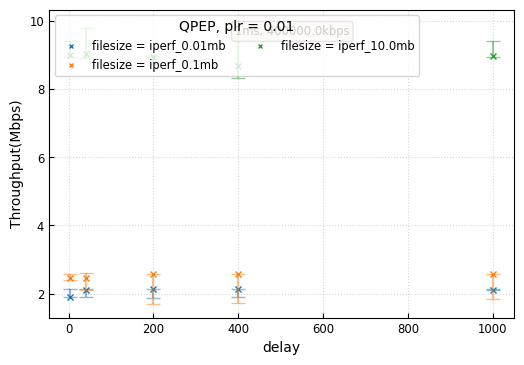

In [76]:
plot_bps_vs_delay(results,bw='400000.0kbps',error='0.01', title="QPEP")

In [70]:
# Now with the plain scenario
my_colours = list(mcolors.TABLEAU_COLORS.values())
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
cca = "Opensand emulation"
folder_path = "./qpep_results/18.08.23/plain_iperf/"

# Get a list of all files in the folder
file_list = os.listdir(folder_path)
# Create dictionary to store the average for each error, rtt, and run
results = {}
for i,filename in enumerate(file_list):
    bandwidth = get_bandwidth(f'{folder_path}{filename}')
    error = get_error(f'{folder_path}{filename}')
    rtt = get_delay(f'{folder_path}{filename}')
    if bandwidth not in results:
        results[bandwidth] = {}
    if error not in results[bandwidth]:
        results[bandwidth][error] = {}
    if rtt not in results[bandwidth][error]:
        results[bandwidth][error][rtt] = {}
    file = open(f'{folder_path}{filename}','rb')
    data = pickle.load(file)
    for filesize in data.keys():
        results[bandwidth][error][rtt][filesize] = np.array(data[filesize]['sent_bps'])/1e6
    file.close()

print(results)

{'700.0kbps': {'1': {'50': {'iperf_0.01mb': array([1.89065, 1.89089, 1.89231, 1.89235, 1.63743]), 'iperf_0.1mb': array([1.7039 , 2.33301, 2.39573, 1.76531, 1.02397]), 'iperf_10.0mb': array([0.687998, 0.704231, 0.673801, 0.72253 , 0.697397])}, '100': {'iperf_0.01mb': array([1.89422, 1.89396, 1.89076, 1.88951, 1.88942]), 'iperf_0.1mb': array([1.61286, 1.50769, 2.39789, 1.7035 , 2.09641]), 'iperf_10.0mb': array([0.69899 , 0.697292, 0.689134, 0.70806 , 0.684957])}, '1': {'iperf_0.01mb': array([1.89007, 1.89194, 1.8895 , 1.89139, 1.63454]), 'iperf_0.1mb': array([2.33212 , 1.31439 , 2.39732 , 1.53185 , 0.987752]), 'iperf_10.0mb': array([0.710912, 0.705342, 0.711565, 0.68984 , 0.68336 ])}, '250': {'iperf_0.01mb': array([1.00673, 1.89148, 1.89152, 1.89294, 1.89118]), 'iperf_0.1mb': array([2.10111, 2.39797, 1.6454 , 2.39508, 2.09843]), 'iperf_10.0mb': array([0.706693, 0.697022, 0.740531, 0.687822, 0.715367])}, '10': {'iperf_0.01mb': array([1.88953, 1.89431, 1.89238, 1.89378, 1.89374]), 'iperf_0

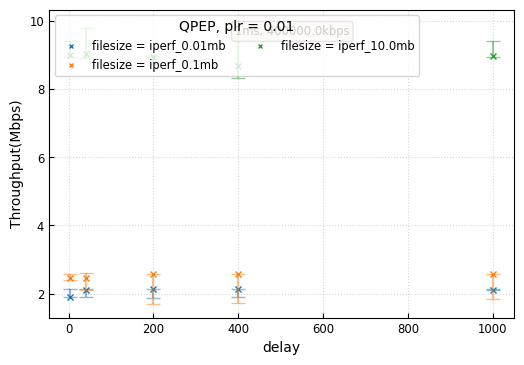

In [72]:
plot_bps_vs_delay(results,bw='400000.0kbps',error='0.01')